In [1]:
import numpy as np
import matplotlib.pyplot as plt

from LIMxCMBL.kernels import *

In [2]:
dchi = np.mean(np.diff(chis))

In [3]:
_tmp_ks = np.logspace(-10, 3, 10000)
_tmp_Pk = np.zeros_like(_tmp_ks)

for k_idx, k in enumerate(_tmp_ks):
    _tmp_Pk[k_idx] = ccl.linear_matter_power(cosmo, k, 1)

In [4]:
ks = 2*np.pi*np.fft.rfftfreq(len(chis), d=dchi)

f_P1Dk = lambda k: np.pi/k * k**3/(2*np.pi**2) * np.interp(np.log(k), np.log(_tmp_ks), _tmp_Pk, left=0, right=0) #units Mpc
P1Dk = f_P1Dk(ks)
P1Dk[0] = 0 #fix NaN

/tmp/ipykernel_223431/910534690.py:3: RuntimeWarning: divide by zero encountered in divide
  f_P1Dk = lambda k: np.pi/k * k**3/(2*np.pi**2) * np.interp(np.log(k), np.log(_tmp_ks), _tmp_Pk, left=0, right=0) #units Mpc
/tmp/ipykernel_223431/910534690.py:3: RuntimeWarning: invalid value encountered in multiply
  f_P1Dk = lambda k: np.pi/k * k**3/(2*np.pi**2) * np.interp(np.log(k), np.log(_tmp_ks), _tmp_Pk, left=0, right=0) #units Mpc
/tmp/ipykernel_223431/910534690.py:3: RuntimeWarning: divide by zero encountered in log
  f_P1Dk = lambda k: np.pi/k * k**3/(2*np.pi**2) * np.interp(np.log(k), np.log(_tmp_ks), _tmp_Pk, left=0, right=0) #units Mpc


In [5]:
n_k_bins = 100
k_bin_edges = np.append([-np.inf], np.exp(np.linspace(np.log(min(ks[12:])), np.log(max(ks)), n_k_bins)))

k_idxs = []
for bin_idx in range(n_k_bins):
    l, r = k_bin_edges[bin_idx], k_bin_edges[bin_idx+1]
    idxs = np.where((ks >= l) & (ks < r))
    k_idxs += [idxs]
    
n_in_k_bin = np.array([len(k_idxs[i][0]) for i in range(n_k_bins)])
print(n_in_k_bin)

[ 12   1   1   1   1   1   1   1   1   1   2   1   1   2   2   1   2   2
   2   3   2   3   2   3   3   4   3   4   4   4   4   5   5   5   6   6
   6   7   7   8   8   8  10   9  11  11  11  13  13  14  15  16  17  18
  19  20  21  23  25  25  28  29  31  33  35  37  40  42  45  47  51  53
  57  61  64  69  73  77  82  88  93  98 105 112 118 126 134 142 151 161
 171 181 193 205 218 232 246 262 278 296]


In [6]:
n_x_bins = 100
x_bin_edges = np.linspace(3000, 4000, n_x_bins+1)
x_bin_centers = (x_bin_edges[1:]+x_bin_edges[:-1])/2


x_idxs = []
for bin_idx in range(n_x_bins):
    l, r = x_bin_edges[bin_idx], x_bin_edges[bin_idx+1]
    idxs = np.where((chis >= l) & (chis < r))
    x_idxs += [idxs]
    
n_in_x_bin = np.array([len(x_idxs[i][0]) for i in range(n_x_bins)])

In [7]:
Kkappa_x = Wk*Dz
Kkappa_k = np.fft.rfft(Kkappa_x) * dchi

In [8]:
Lambdas = [0.0, 1e-1]

In [9]:
KI.value

array([4.83997476e-01, 4.84333385e-01, 4.84668454e-01, ...,
       1.14819292e-53, 1.13434128e-53, 1.12063476e-53])

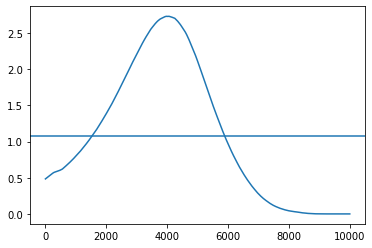

In [10]:
plt.plot(KI.value)
plt.axhline(np.mean(KI.value))

In [11]:
from scipy.integrate import trapezoid
def gen_fields():
    white_x = np.random.normal(loc=0., scale=1./np.sqrt(dchi), size=len(chis))
    white_k = np.fft.rfft(white_x) * dchi
    delta_m_k = np.sqrt(P1Dk) * white_k 
    delta_m_x = np.fft.irfft(delta_m_k) / dchi
    
    kappa = trapezoid(x=chis, y = Wk * Dz * delta_m_x)
    
    #KI units kJy/sr
    I_x = KI.value * delta_m_x
    I_k = np.fft.rfft(I_x) * dchi
    I_k_filtered = {}
    for Lambda in Lambdas:
        I_k_filtered[Lambda] = np.where((ks >= Lambda), I_k, 0) 
    I_x_filtered = {Lambda : np.fft.irfft(I_k_filtered[Lambda])/dchi for Lambda in Lambdas}
    
    I_x_noLC = np.mean(KI.value) * delta_m_x
    I_k_noLC = np.fft.rfft(I_x_noLC) * dchi
    I_k_noLC_filtered = {}
    for Lambda in Lambdas:
        I_k_noLC_filtered[Lambda] = np.where((ks >= Lambda), I_k_noLC, 0) 
    I_x_noLC_filtered = {Lambda : np.fft.irfft(I_k_noLC_filtered[Lambda])/dchi for Lambda in Lambdas}
    
    return kappa, I_x_filtered, I_k_filtered, I_x_noLC_filtered, I_k_noLC_filtered

In [12]:
from tqdm import trange

In [13]:
from scipy.interpolate import interp1d

KI_k = np.fft.rfft(KI.value) * dchi
_f_KI_k = interp1d(x = ks, y = KI_k, fill_value = 0, bounds_error=False)
_f_Kkappa_k = interp1d(x = ks, y = Kkappa_k, fill_value = 0, bounds_error=False)

def f_KI(k):
    _idx1 = np.where(k<0)
    _idx2 = np.where(k>=0)
    ret = np.zeros_like(k, dtype=np.complex128)
    if(len(_idx1[0]) > 0):
        ret[_idx1] = np.conj(_f_KI_k(np.abs(k[_idx1])))
    if(len(_idx2[0]) > 0):
        ret[_idx2] = _f_KI_k(k[_idx2])
    return ret

def f_Kkappa(k):
    if(k<0):
        return np.conj(_f_Kkappa_k(np.abs(k)))
    
    return _f_Kkappa_k(k)
def integrand(q,):
    return f_KI(ks-q)*f_Kkappa(q)*f_P1Dk(np.abs(q))

# _k = ks.reshape(-1, 1)
# _q = ks.reshape(1, -1)
# IkKappa = trapezoid(x=_q, y=f_KI_k(_k-_q) * Kkappa_k.reshape(1, -1) * P1Dk.reshape(1, -1))

In [14]:
from scipy.integrate import quad_vec
IkKappa, err = quad_vec(integrand, -np.inf, np.inf, epsabs = 0.0, epsrel = 1e-3)

Text(0.5, 1.0, 'no lightcone')

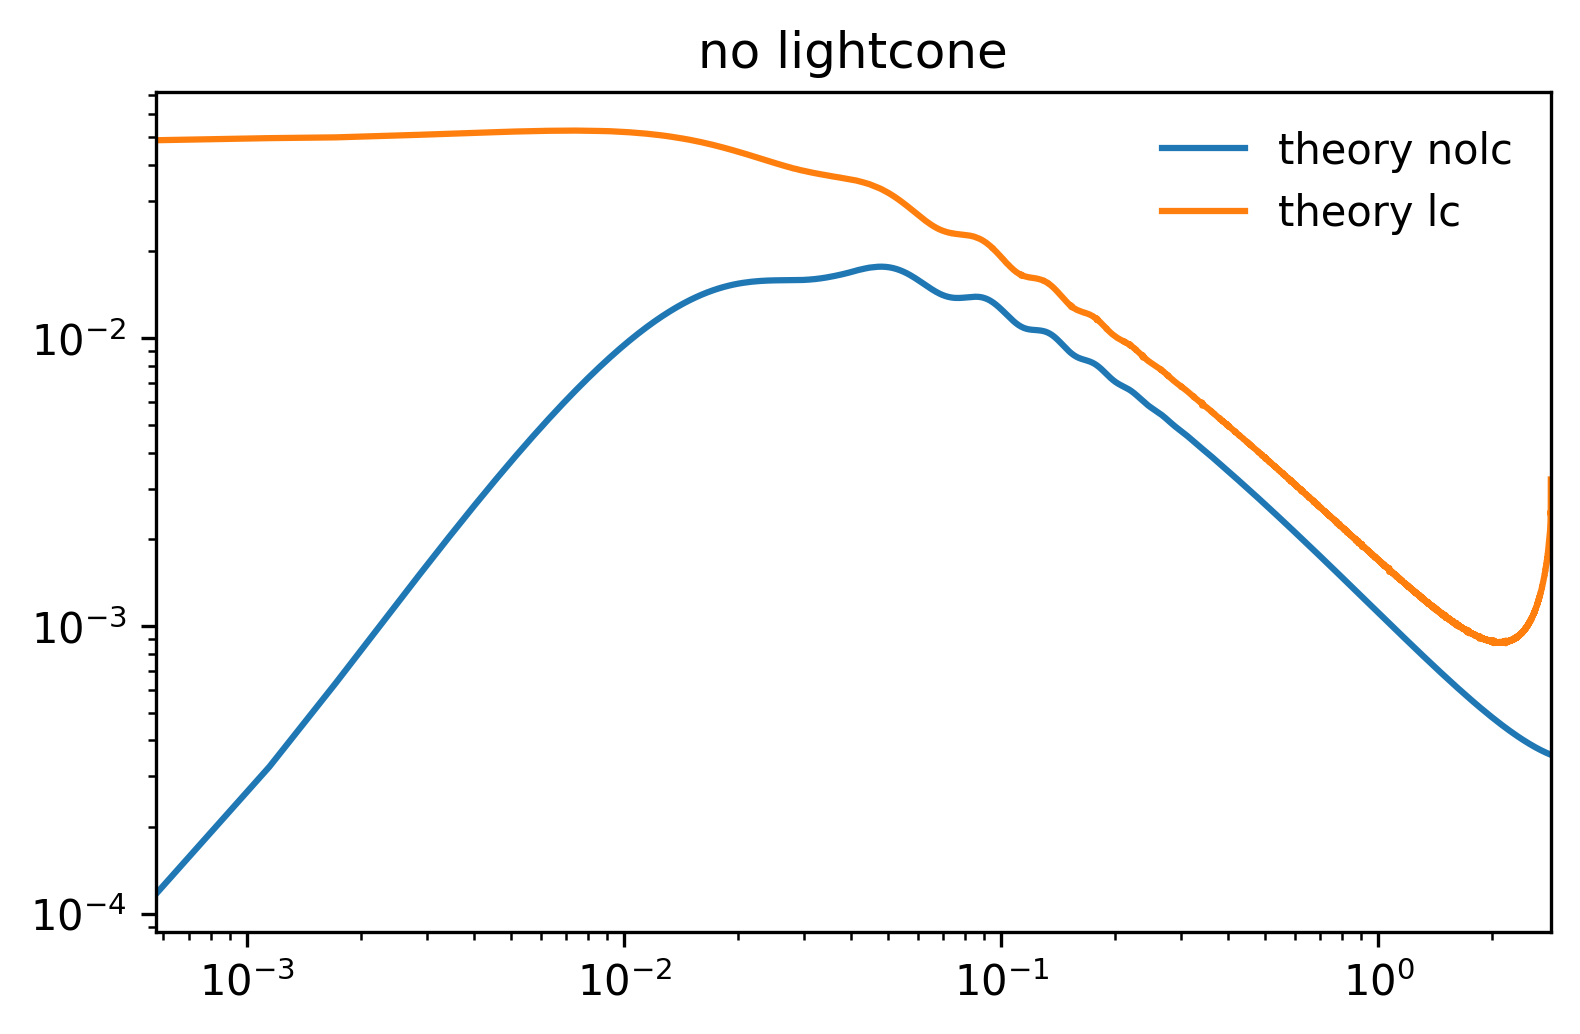

In [15]:
plt.figure(figsize=(6,6/1.618), dpi=300)    
plt.plot(ks, np.abs(np.mean(KI.value)*P1Dk*Kkappa_k), label='theory nolc')
plt.plot(ks, np.abs(IkKappa), label='theory lc')
plt.xscale('log')
plt.legend(frameon=False)
# plt.ylim(1e-5, 0.3)
plt.yscale('log')

plt.xlim(2*np.pi/chimax_sample, max(ks))
plt.title('no lightcone')

In [21]:
n_runs = 4*120000
# n_runs = 1200
out_spectra_k = {Lambda:np.zeros(n_k_bins, dtype=np.complex128) for Lambda in Lambdas}
out_spectra_noLC_k = {Lambda:np.zeros(n_k_bins, dtype=np.complex128) for Lambda in Lambdas}


out_spectra_x = {Lambda:np.zeros(n_x_bins, dtype=np.complex128) for Lambda in Lambdas}
out_spectra_noLC_x = {Lambda:np.zeros(n_x_bins, dtype=np.complex128) for Lambda in Lambdas}

for _ in trange(n_runs):
    kappa, I, I_k, I_noLC, I_noLC_k = gen_fields()
    
    
    for bin_idx in range(n_k_bins):
        idxs = k_idxs[bin_idx]
        for Lambda in Lambdas:
            out_spectra_k[Lambda][bin_idx]      += np.sum(kappa * I_k[Lambda][idxs])
            out_spectra_noLC_k[Lambda][bin_idx] += np.sum(kappa * I_noLC_k[Lambda][idxs])
            
            
    for bin_idx in range(n_x_bins):
        idxs = x_idxs[bin_idx]
        for Lambda in Lambdas:
            out_spectra_x[Lambda][bin_idx]      += np.sum(kappa * I[Lambda][idxs])
            out_spectra_noLC_x[Lambda][bin_idx] += np.sum(kappa * I_noLC[Lambda][idxs])

100%|██████████| 480000/480000 [1:05:16<00:00, 122.55it/s]


Text(0.5, 1.0, 'no lightcone')

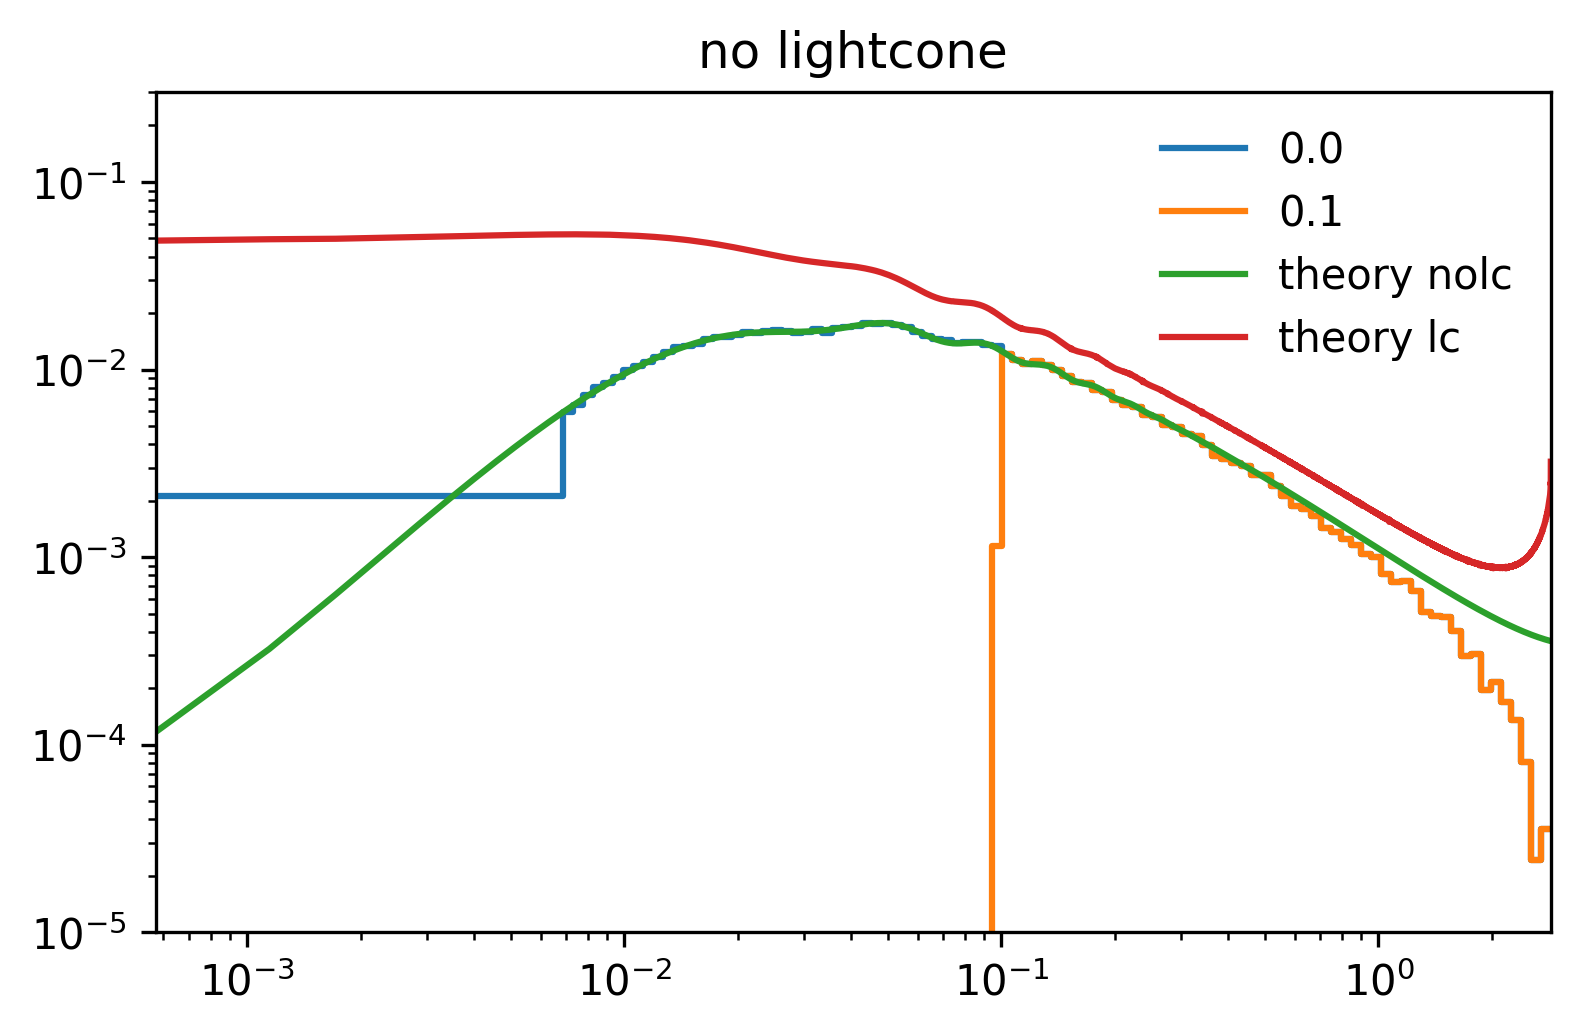

In [22]:
plt.figure(figsize=(6,6/1.618), dpi=300)
for Lambda in Lambdas:
    curr_spectra= np.abs(out_spectra_noLC_k[Lambda]/(n_in_k_bin * n_runs))
    plt.step(k_bin_edges, np.append(curr_spectra, [curr_spectra[-1]], ), 
                 where='post', label=Lambda)
    
plt.plot(ks, np.abs(np.mean(KI.value)*P1Dk*Kkappa_k), label='theory nolc')
plt.plot(ks, np.abs(IkKappa), label='theory lc')
plt.xscale('log')
plt.legend(frameon=False)
plt.ylim(1e-5, 0.3)
plt.yscale('log')

plt.xlim(2*np.pi/chimax_sample, max(ks))
plt.title('no lightcone')

Text(0.5, 1.0, 'lightcone')

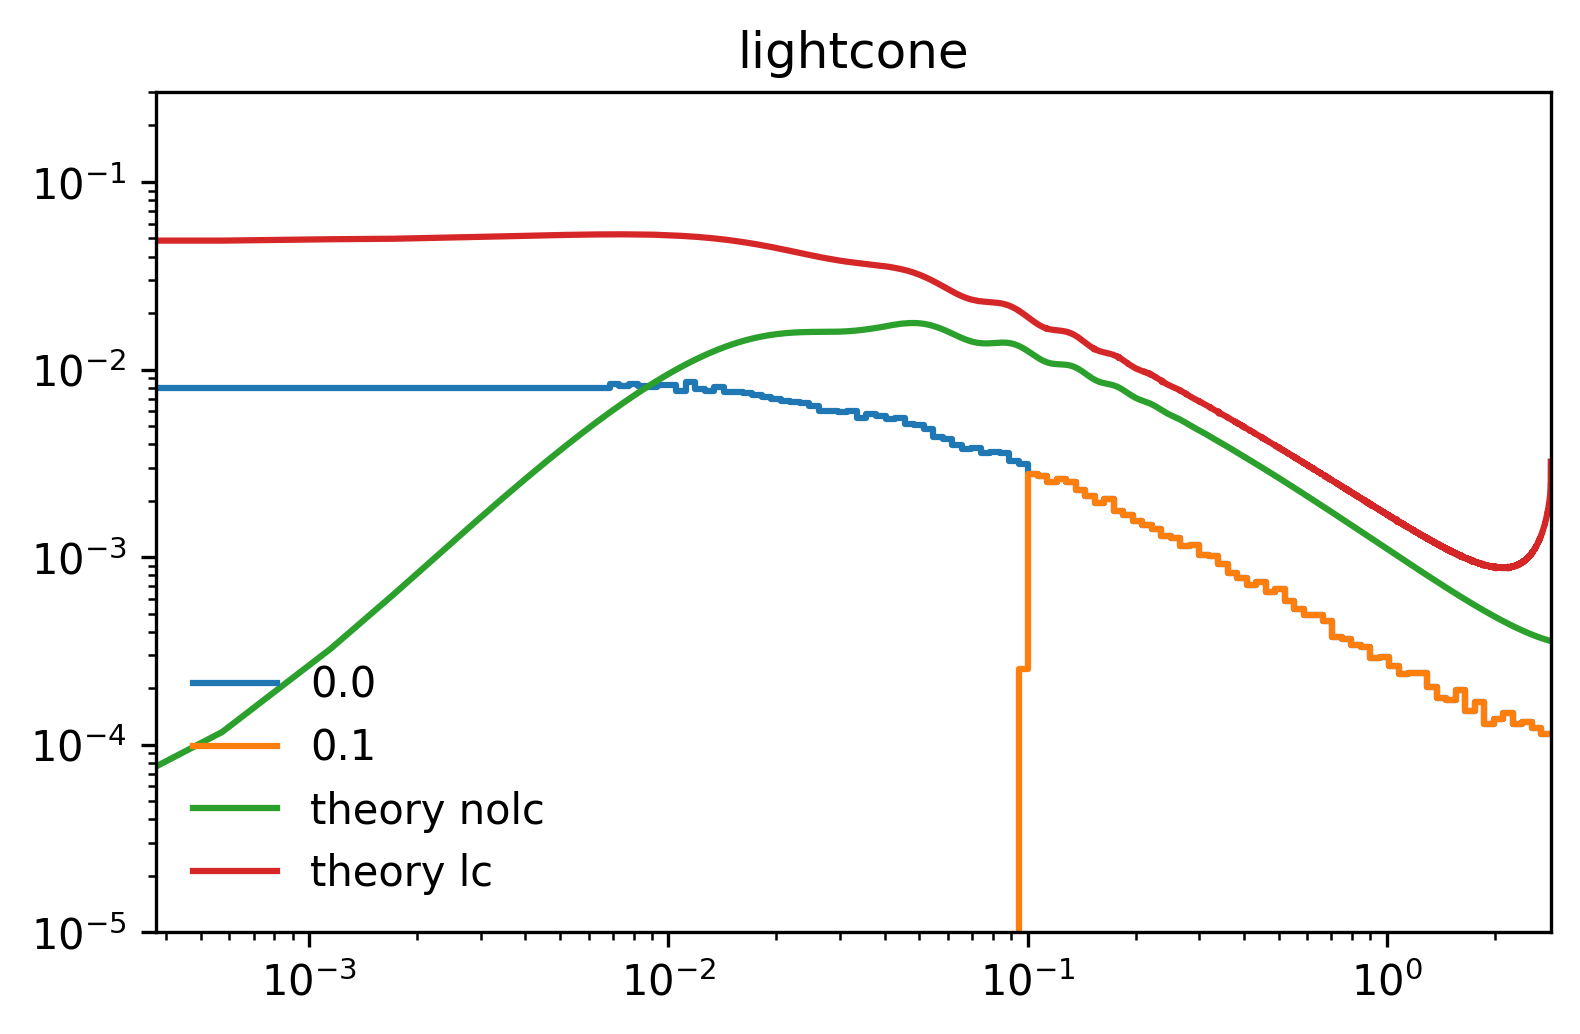

In [23]:
plt.figure(figsize=(6,6/1.618), dpi=300)
for Lambda in Lambdas:
    curr_spectra= np.abs(out_spectra_k[Lambda]/(n_in_k_bin * n_runs))
    plt.step(k_bin_edges, np.append(curr_spectra, [curr_spectra[-1]], ), 
                 where='post', label=Lambda)
    
plt.plot(ks, np.abs(np.mean(KI.value)*P1Dk*Kkappa_k), label='theory nolc')
plt.plot(ks, np.abs(IkKappa), label='theory lc')
plt.xscale('log')
plt.legend(frameon=False)
plt.ylim(1e-5, 0.3)
plt.yscale('log')
plt.xlim(None, max(ks))
plt.title('lightcone')

Text(0.5, 1.0, 'no lightcone')

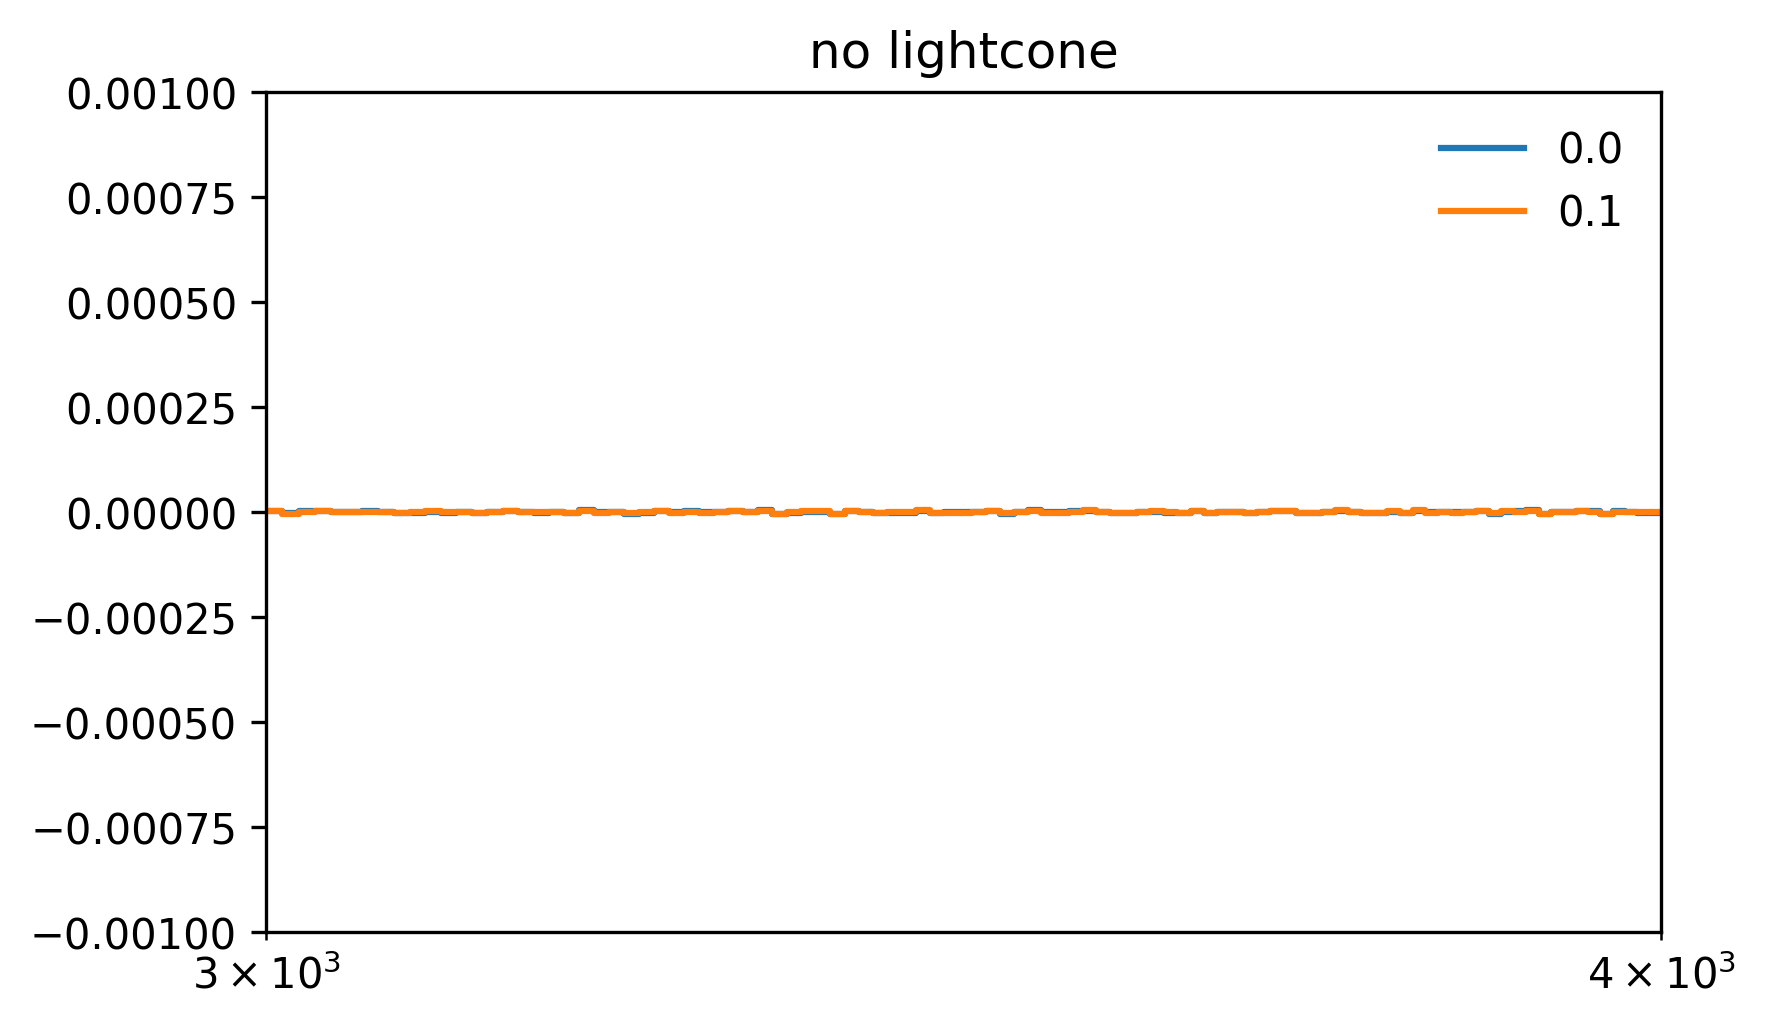

In [24]:
plt.figure(figsize=(6,6/1.618), dpi=300)
for Lambda in Lambdas:
    curr_spectra= out_spectra_noLC_x[Lambda]/(n_in_x_bin*n_runs)
    plt.step(x_bin_edges, np.append(curr_spectra, [curr_spectra[-1]], ), 
                 where='post', label=Lambda)
    
plt.xscale('log')
plt.legend(frameon=False)

plt.ylim(-0.001, 0.001)
plt.xlim(min(x_bin_edges), max(x_bin_edges))
plt.title('no lightcone')

Text(0.5, 1.0, 'lightcone')

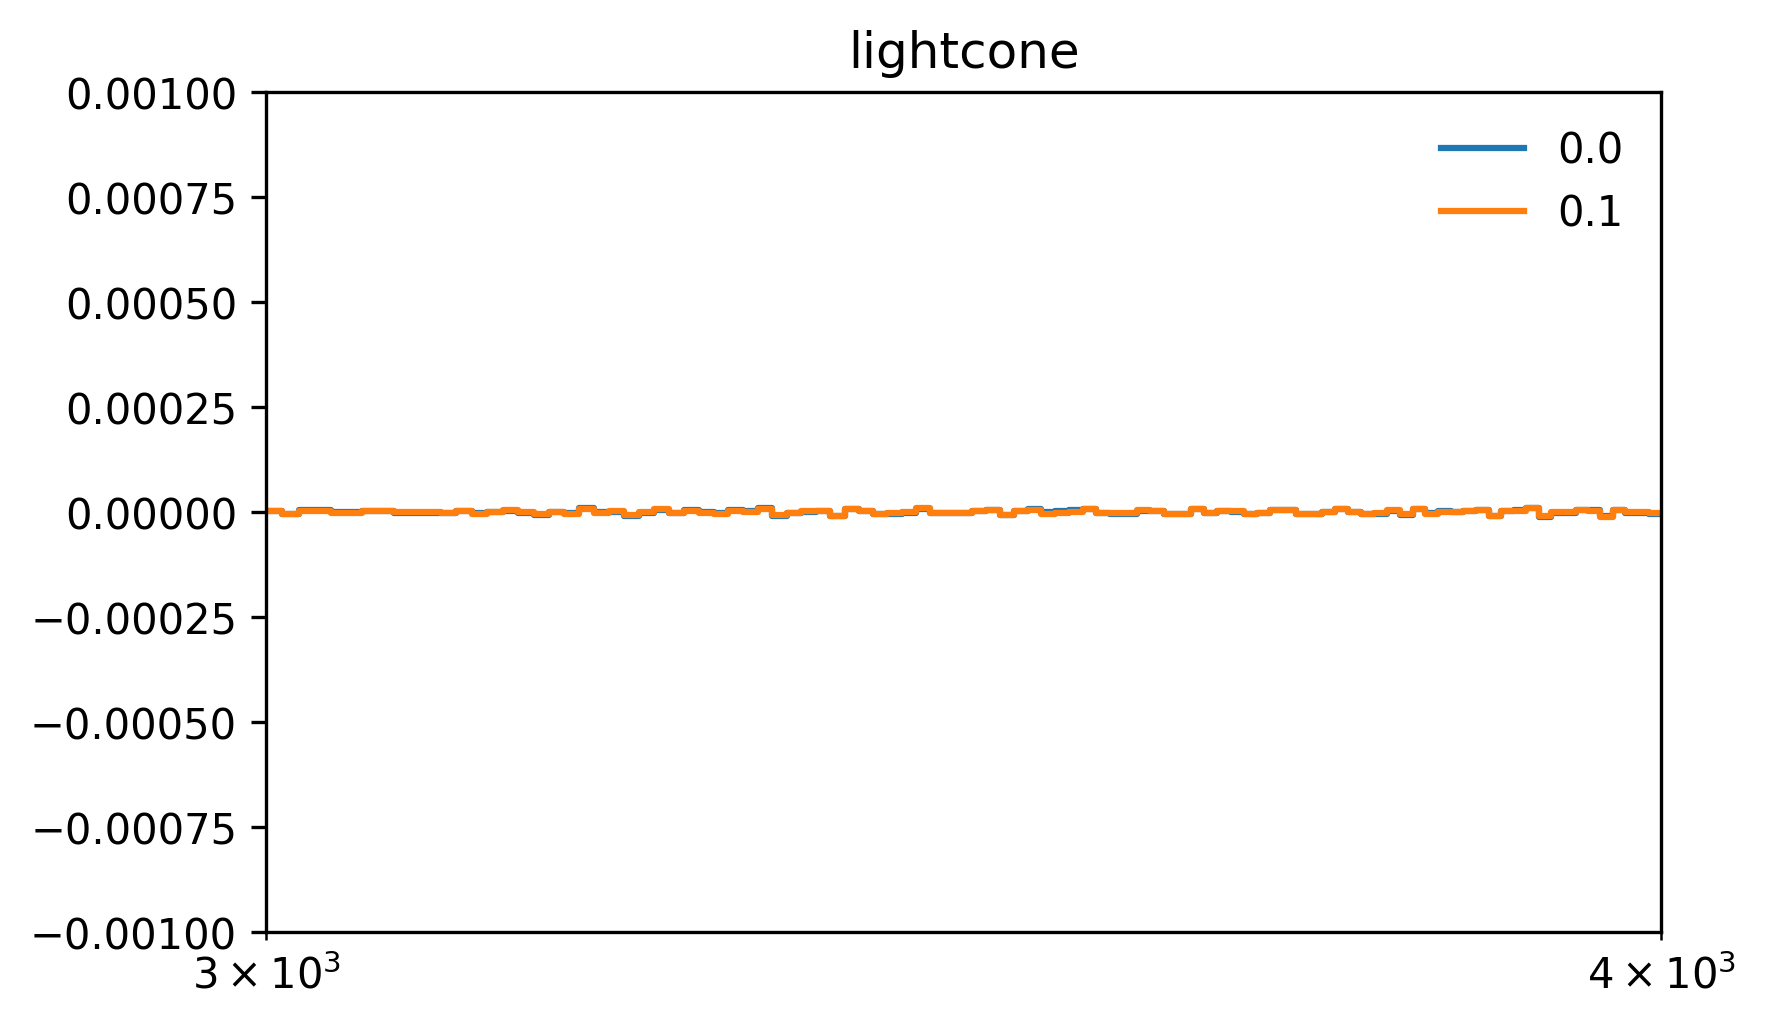

In [25]:
plt.figure(figsize=(6,6/1.618), dpi=300)
for Lambda in Lambdas:
    curr_spectra= out_spectra_x[Lambda]/(n_in_x_bin*n_runs)
    plt.step(x_bin_edges, np.append(curr_spectra, [curr_spectra[-1]], ), 
                 where='post', label=Lambda)
    
plt.xscale('log')
plt.legend(frameon=False)
plt.ylim(-0.001, 0.001)
plt.xlim(min(x_bin_edges), max(x_bin_edges))
plt.title('lightcone')